# Предсказание количества заказов для компании "Четенькое такси"

**Описание:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта:** Построить модель для предсказания количества заказов на следующий час.

**Ход проекта:**
1. Загрузка и ресемплирование
2. Анализ данных
3. Обучение моделей
4. Проверка данных на тестовой выборке и вывод

**Вывод**


## 1. Загрузка и предобработка данных

Загрузим необходимые библиотеки инструменты для работы

In [1]:
!pip install -Uq scikit-learn
!pip install lightgbm -q
!pip install catboost -q

In [2]:
#импорт бибилиотек для работы с датасетами
import pandas as pd
import numpy as np

# импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# импорт бибилотек МО
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# импорт инструментов для предобработки данных для МО
import optuna
from sklearn.model_selection import (
                                TimeSeriesSplit, 
                                train_test_split, 
                                GridSearchCV, 
                                cross_val_score)

# импорт инструментов для анализа временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose

# импорт метрик
from sklearn.metrics import root_mean_squared_error

In [3]:
try:
    taxi = pd.read_csv('C:/Users/anysh/Desktop/Практикум/12. Временные ряды/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi = taxi.sort_index()
taxi.index.is_monotonic_increasing

True

Данные монотонны, переходим к ресемплингу

In [7]:
taxi = taxi.resample('1H').sum()

C:\Users\anysh\AppData\Local\Temp\ipykernel_68320\1260743984.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  taxi = taxi.resample('1H').sum()


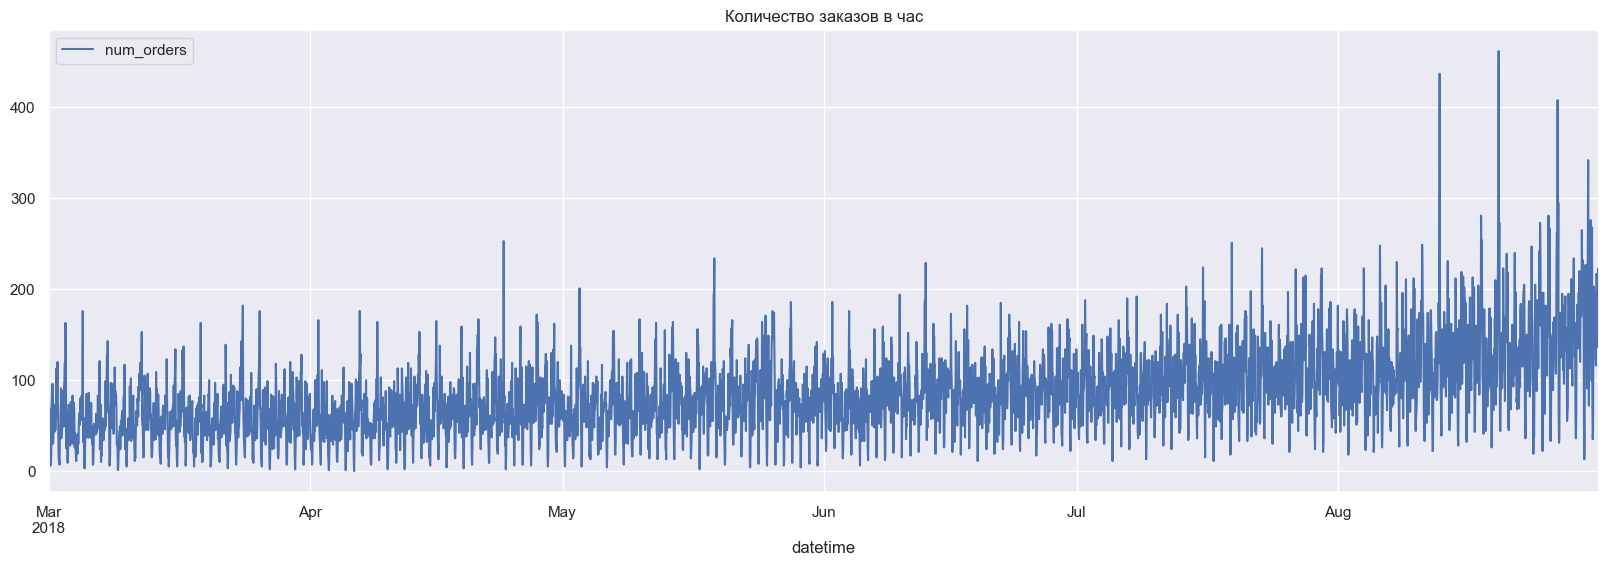

In [8]:
plt.figure(figsize=(20,6))
taxi.plot(ax=plt.gca())
plt.title('Количество заказов в час')
plt.show()

Перейдем к анализу данных

## 2. Анализ данных

Проверим данные на наличие дубликатов, пропусков, а также сезонности, трендов и шумов.

### 2.1 Проверка на наличие пропусков и дубликатов

In [9]:
taxi.isna().sum()

num_orders    0
dtype: int64

Пропусков не нашли, идем дальше к дубликатам.

In [10]:
taxi.index.duplicated().sum()

0

Пропусков и дубликатов нет. Перейдем к оценке сезонности, трендов, шумов.

### 2.2 Сезонность, тренды и шумы

In [11]:
decomposed = seasonal_decompose(taxi)

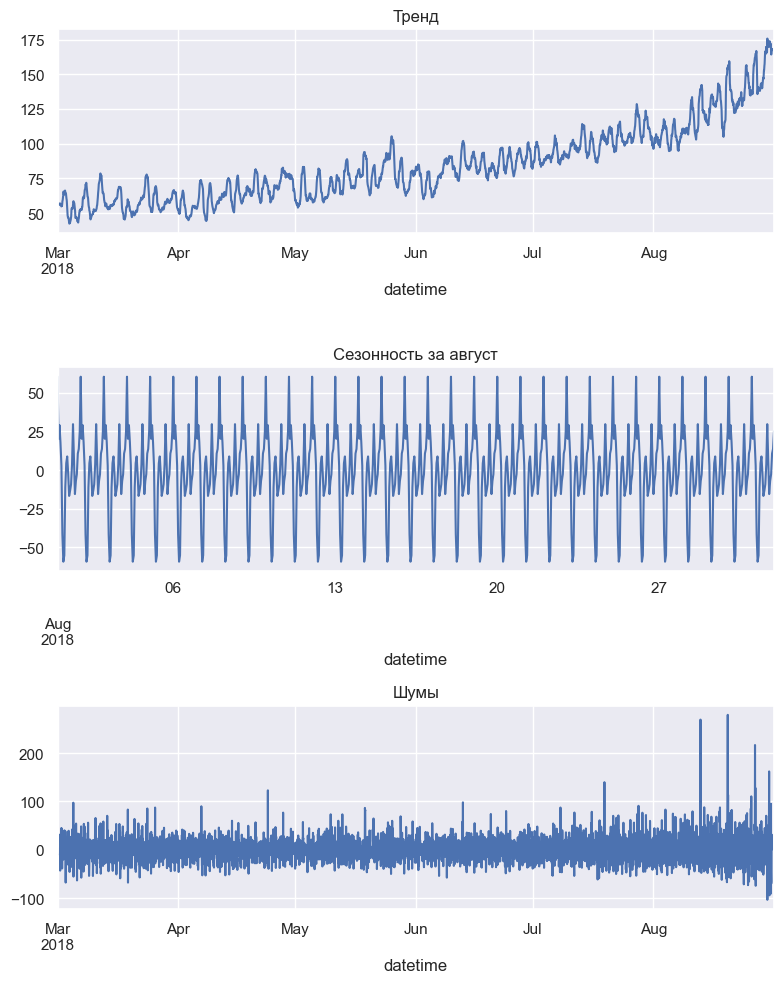

In [12]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность за август')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.tight_layout()

Еще мы можем проанализировать скользящее среднее по неделям (т.к. в данных нам предоставлены данные только за период с марта по август 2018 года)

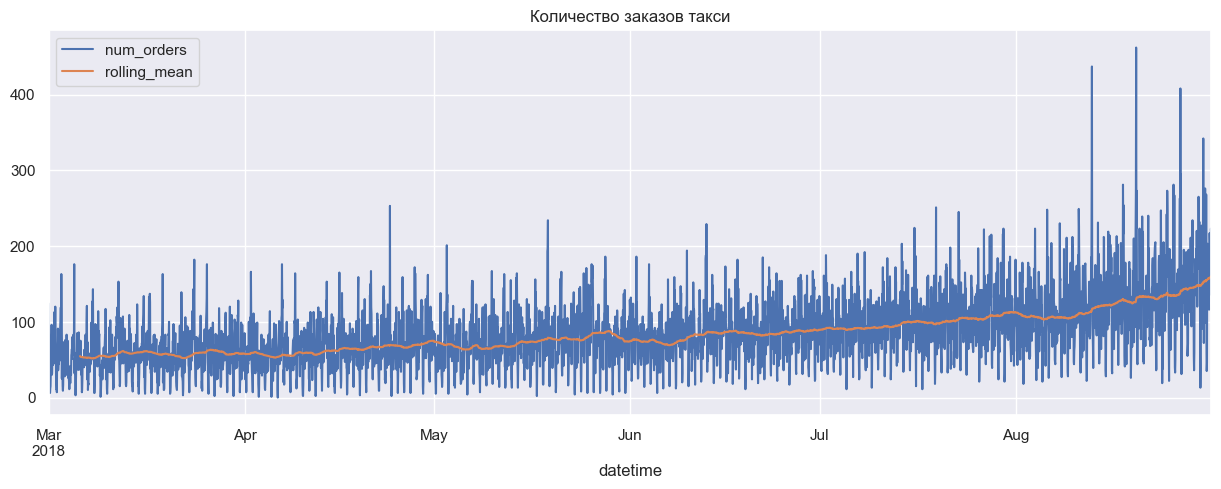

In [13]:
taxi['rolling_mean'] = taxi.rolling(120).mean()
plt.figure(figsize=(15,5))
plt.title("Количество заказов такси")
taxi.plot(ax=plt.gca())
plt.show()

Мы видим, что среднее значение повышается в агусте. Было бы полезно посмотреть данные за последние две недели данных.

In [14]:
decomposed_week_1 = seasonal_decompose(taxi['num_orders']['2018-08-17':'2018-08-24'])
decomposed_week_2 = seasonal_decompose(taxi['num_orders']['2018-08-24':'2018-08-31'])

In [15]:
def decomposed_func(x):
    plt.figure(figsize=(8, 10))
    plt.subplot(311)
    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    x.trend.plot(ax=plt.gca())
    plt.title('Тренд')
    plt.subplot(312)
    x.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность за август')
    plt.subplot(313)
    x.resid.plot(ax=plt.gca())
    plt.title('Шумы')
    plt.tight_layout()

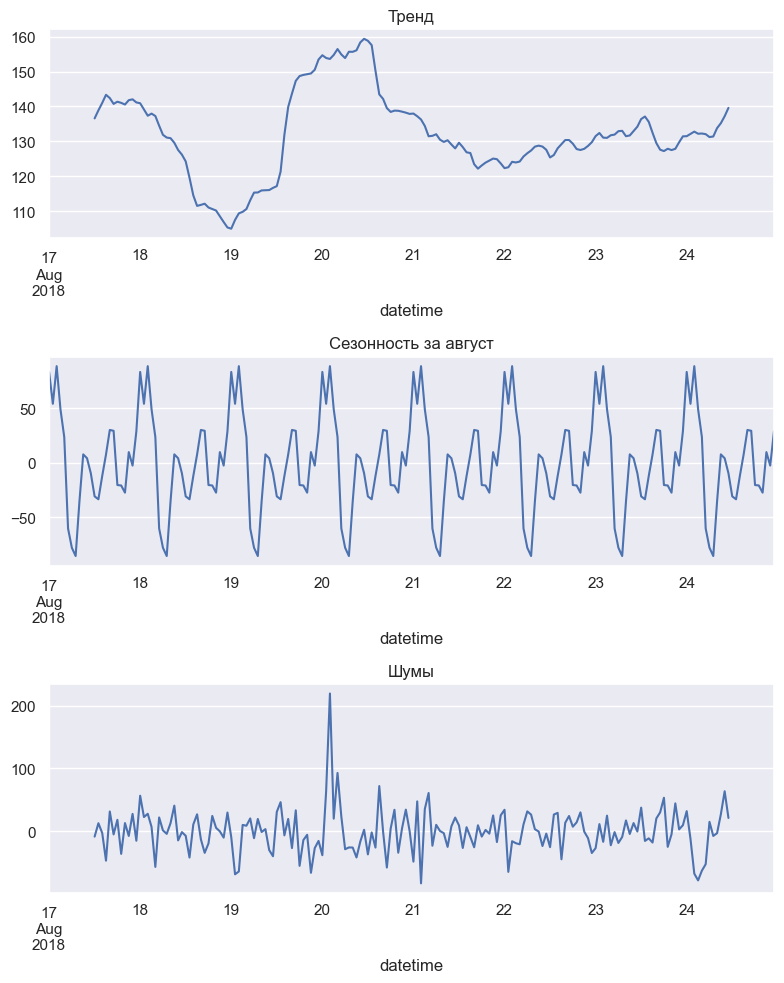

In [16]:
decomposed_func(decomposed_week_1)

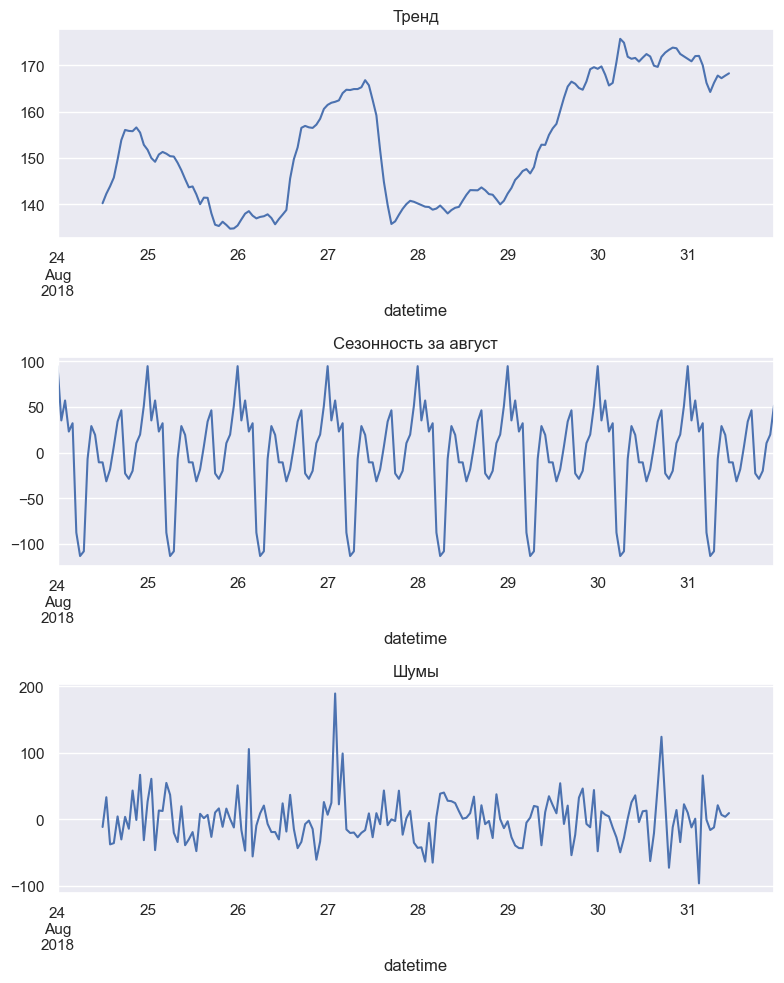

In [17]:
decomposed_func(decomposed_week_2)

Судя по графикам, больше такси используют в выходные (17, 18, 19 августа), а также по понедельникам (20 и 27 августа). Временные ряды - стационарны.

## 3. Обучение моделей

Мы будем использовать 3 модели:
1. LinearRegression
2. CatBoostRegressor
3. LGBMRegressor

А также для подбора гиперпараметров для этих моделей будем использовать GridSearchCV. Также мы добавим больше признаков с помощью пользовательской функции.

In [18]:
def make_features(data: pd.DataFrame, max_lag: int, rolling_mean_size: int)-> pd.DataFrame:

    data_1 = data.copy()
    data_1 = data_1.drop(['rolling_mean'], axis=1) # удаляем уже имеющийся столбец
    data_1['day'] = data_1.index.day # номер дня
    data_1['dayofweek'] = data_1.index.dayofweek # номер дня недели от 0 до 6
    data_1['hour'] = data_1.index.hour # час
    
    for lag in range(1, max_lag + 1): # отстающие значения
        data_1['lag_{}'.format(lag)] = data_1['num_orders'].shift(lag)

    data_1['rolling_mean'] = data_1['num_orders'].shift().rolling(rolling_mean_size).mean() # скользящее среднее

    return data_1

In [19]:
taxi = make_features(taxi, 24, 24)
taxi = taxi.dropna()

In [20]:
taxi.head(5)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Также разделим данные на тренировочные и тестовую выборки

In [21]:
X = taxi.drop('num_orders' , axis=1)
y = taxi['num_orders'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

### 3.1 LinearRegression

In [23]:
# print("Training LinearRegression...")
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
# lr.fit(X_train, y_train)
# y_pred_lr = lr.predict(X_valid)
# lr_score = root_mean_squared_error(y_valid, y_pred_lr)
# print(f"LinearRegression RMSE: {lr_score:.4f}")

In [24]:
rmse_score_list = - cross_val_score(
                            estimator=lr, 
                            X=X_train, 
                            y=y_train, 
                            cv=tscv,  
                            scoring='neg_root_mean_squared_error')

val_score = rmse_score_list.mean()
f"LinearRegression RMSE на кросс-валидации: {val_score:.4f}"

'LinearRegression RMSE на кросс-валидации: 27.1515'

### 3.2 LGBMRegressor с GridSearch

In [26]:
model_LGBM = LGBMRegressor(objective='regression', verbosity=-1)

In [27]:
param_distributions = {  
        'learning_rate': [0.05, 0.2, 0.3, 0.35],  
        'max_depth': [3, 6, 10, 12],  
        'min_child_samples': [20, 50],
        'n_estimators': [100, 500],
        'reg_alpha': [0.1, 1.0]
 }

gridsearch_lgbm = GridSearchCV(
    estimator=model_LGBM,
    param_grid=param_distributions,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

gridsearch_lgbm.fit(X_train, y_train)
f'качество модели LGBM при кросс-валидации равно {gridsearch_lgbm.best_score_ *-1}'

'качество модели LGBM при кросс-валидации равно 24.77232687385666'

LGBMRegressor справилась лучше, чем линейная регрессия. Перейдем к CatBoostClassifier

### 3.3 CatBoostRegressor с GridSearch

In [30]:
model_catboost = CatBoostRegressor(verbose=False)

In [31]:
param_distributions = {
        'iterations' : [200, 400],
        'learning_rate': [0.05, 0.2, 0.3, 0.35],  
        'depth': [4, 6],  
        'l2_leaf_reg': [0.1, 0.2, 0.4, 1.0]
 }

gridsearch_catboost = GridSearchCV(
    estimator=model_catboost,
    param_grid=param_distributions,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

gridsearch_catboost.fit(X_train, y_train)
f'качество модели CatBoost при кросс-валидации равно {gridsearch_catboost.best_score_*-1}'

'качество модели CatBoost при кросс-валидации равно 24.2490393972125'

Мы обучили три модели с использованием GridSearchCV, и нашей целевой метрике RMSE соответствуют все три модели на кросс-валидации. Выберем лучшую, сделаем предсказания на тестовой выборке и оформим выводы

## 4. Анализ и выводы

In [33]:
display('Сравнение моделей')
display(f"LinearRegression RMSE: {val_score:.4f}")
display(f"LGBMRegressor RMSE: {gridsearch_lgbm.best_score_ *-1:.4f}")
f"CatBoostRegressor RMSE: {gridsearch_catboost.best_score_*-1:.4f}"

'Сравнение моделей'

'LinearRegression RMSE: 27.1515'

'LGBMRegressor RMSE: 24.7723'

'CatBoostRegressor RMSE: 24.2490'

Лучше всех справилась модель CatBoostRegressor, проверим модель на тестовой выборке

In [34]:
cb_y_pred_test = gridsearch_catboost.best_estimator_.predict(X_test)
cb_score_test = root_mean_squared_error(y_test, cb_y_pred_test)
display(f"Лучшие параметры модели: {gridsearch_catboost.best_params_}")
f"CatBoostRegressor: {cb_score_test:.4f}"

"Лучшие параметры модели: {'depth': 6, 'iterations': 400, 'l2_leaf_reg': 0.2, 'learning_rate': 0.05}"

'CatBoostRegressor: 40.0911'

При этом оценка на тестовых значениях данная модель справляется и метрика меньше 48.

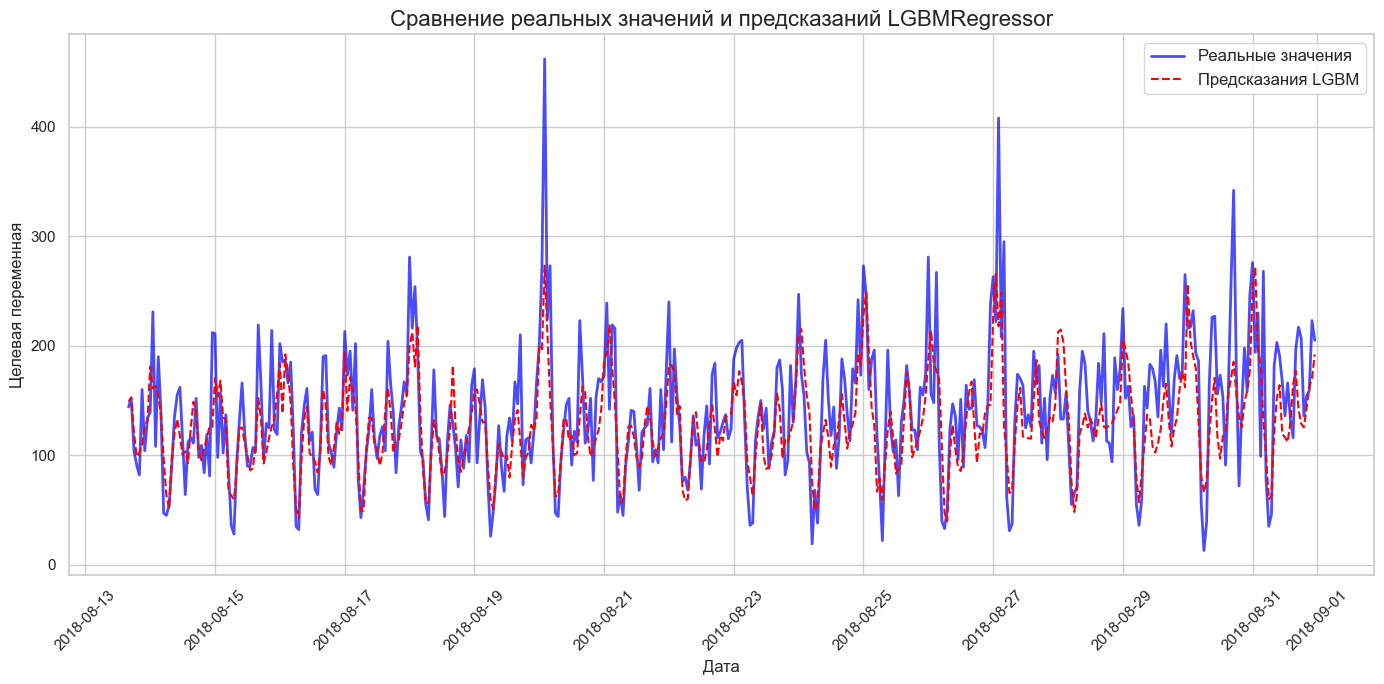

In [35]:
# Создаем DataFrame
results = pd.DataFrame({
    'Дата': X_test.index,  # предполагаем, что индекс содержит даты/время
    'Реальные значения': y_test,
    'Предсказания LGBM': cb_y_pred_test
}).set_index('Дата')

# Стиль графиков
sns.set(style='whitegrid', palette='muted')
plt.figure(figsize=(14, 7))

# График временного ряда
plt.plot(results.index, results['Реальные значения'], label='Реальные значения', 
         color='blue', alpha=0.7, linewidth=2)
plt.plot(results.index, results['Предсказания LGBM'], label='Предсказания LGBM', 
         color='red', linestyle='--', linewidth=1.5)

# Настройки отображения
plt.title('Сравнение реальных значений и предсказаний LGBMRegressor', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Целевая переменная', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

Мы видим, что модель относительно хорошо предсказывает значения и колебания (визуально). Проверим данную модель на адекватность, сравнив с метркиами DummyRegressor.

Mean: RMSE = 84.6877
Median: RMSE = 87.2109
Last Value: RMSE = 68.5089
Seasonal Last (24h): RMSE = 60.1513


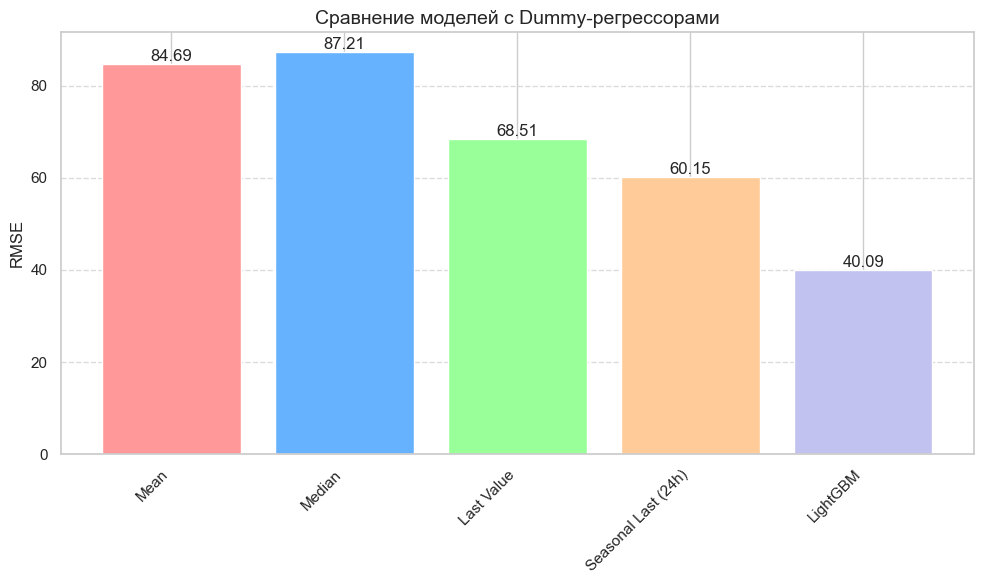


Анализ адекватности:
⚠️ LightGBM лучше, но стоит проверить переобучение


In [36]:
dummy_models = {
    "Mean": DummyRegressor(strategy="mean"),
    "Median": DummyRegressor(strategy="median"),
    "Last Value": DummyRegressor(strategy="constant", constant=y_train.iloc[-1]),
    "Seasonal Last (24h)": DummyRegressor(strategy="constant", constant=y_train.iloc[-24])
}

results = {}
for name, model in dummy_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = (root_mean_squared_error(y_test, y_pred))
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.4f}")

lgbm_rmse = cb_score_test
results["LightGBM"] = lgbm_rmse

plt.figure(figsize=(10, 6))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#c2c2f0']
bars = plt.bar(results.keys(), results.values(), color=colors)

plt.title("Сравнение моделей с Dummy-регрессорами", fontsize=14)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nАнализ адекватности:")
if lgbm_rmse < min(results.values()):
    print("✅ LightGBM значительно лучше Dummy-моделей")
elif lgbm_rmse < 1.25 * min(results.values()):
    print("⚠️ LightGBM лучше, но стоит проверить переобучение")
else:
    print("❌ LightGBM работает хуже простых стратегий!")

Мы видим, что при нынешних данных значение модели CatBoostRegressor лучше, чем на DummyRegressor, но можно улучшить результат, снизив количество гиперпараметров или их перебор.

## Выводы

Мы провели работу с временными рядами, проверили данные на наличие пропусков и дубликатов, а также посомтрели на наличие сезонности и трендов, шумов. Мы выявили визуально, что среднеее количество заказов имеет тенденцию к уведичнию, а также пик заказов приходится на дни с пятницы по воскресенье и на понедельники.

Мы решили обучить три модели: LinearRegression, CatBoostRegressor и LGBMRegressor с перебором гиперпараметров с помощью перебора по сетке GridSearchCV. По итогу обучения самой лучшей моделью на тестовой выборке стала CatBoostRegressor с метрикой RMSE на тествой выборке 40.09. Также мы ее сравнили с DummyRegressor, и выяснили, что можно улучшить модель, поработав с переобучением.